In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from vcc_growing_season import PROJECT_ROOT_DIR
from vcc_growing_season.county_stats import GrowingSeasons, tmin_to_growing_season

## Demo showing derivation of growing season from daily minimum temperature data per county 

### 1. Ingest processed US tmin data + calculate growing season trends for state of Virigina

In [2]:
tmin_filepath = PROJECT_ROOT_DIR.joinpath("data/tmin_all.csv")
tmin = pd.read_csv(tmin_filepath)

# Reduce to VA counties, remove spurious no-data rows
VA_columns = ["date"] + [col for col in tmin.columns if col.startswith("VA")]
tmin = tmin[VA_columns].dropna()

# Cast date column to datetime
tmin["date"] = pd.to_datetime(tmin.date)
tmin = tmin.sort_values(by="date").reset_index(drop=True).set_index('date')

print(f"Start date: {tmin.index.min()}")
print(f"End date: {tmin.index.max()}")

Start date: 1951-01-01 00:00:00
End date: 2022-12-31 00:00:00


In [3]:
# Define growing seasons
va_growing_seasons = tmin_to_growing_season(tmin)
regression_results = va_growing_seasons.get_linear_trends()

### 2. Plot results by county

In [4]:
# Load VA county boundaries
counties_filepath = PROJECT_ROOT_DIR.joinpath("data/Virginia City_County Boundaries.geojson")
counties = gpd.read_file(counties_filepath)

# join regression trends results
counties = pd.merge(counties, regression_results, on="namelsad", how="left")

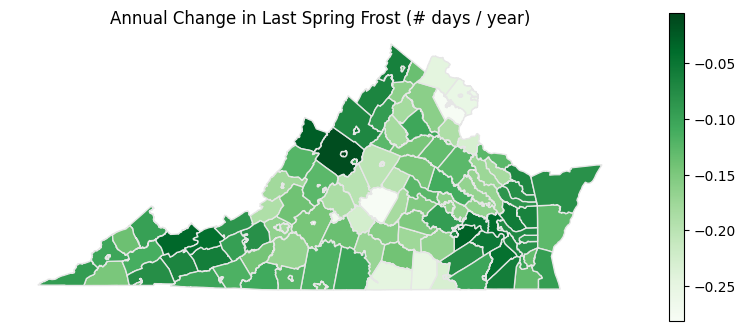

In [5]:
fig, ax = plt.subplots(figsize=(10,4))
counties.plot(column='season_start_slope', cmap='Greens', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')
ax.set_title("Annual Change in Last Spring Frost (# days / year)")
plt.show()

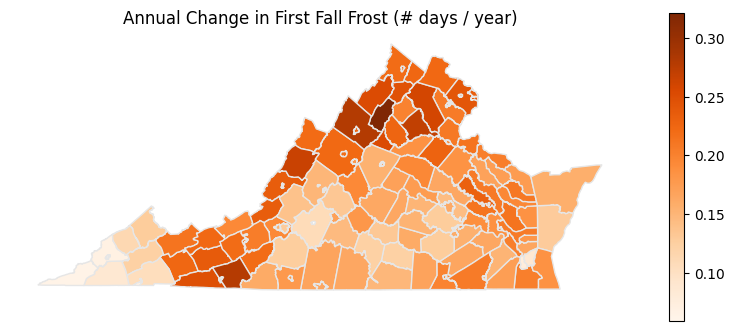

In [6]:
fig, ax = plt.subplots(figsize=(10,4))
counties.plot(column='season_end_slope', cmap='Oranges', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')
ax.set_title("Annual Change in First Fall Frost (# days / year)")
plt.show()

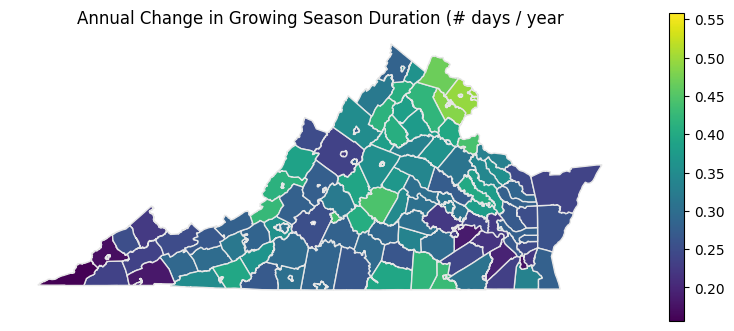

In [7]:
fig, ax = plt.subplots(figsize=(10,4))
counties.plot(column='growing_season_duration_slope', cmap='viridis', linewidth=1, ax=ax, edgecolor='0.9', legend=True)
ax.axis('off')
ax.set_title("Annual Change in Growing Season Duration (# days / year")
plt.show()

### 3. Plot time series averaged across all VA counties

In [9]:
rolling_annual_window = 10  # rolling average helps smooth the time series

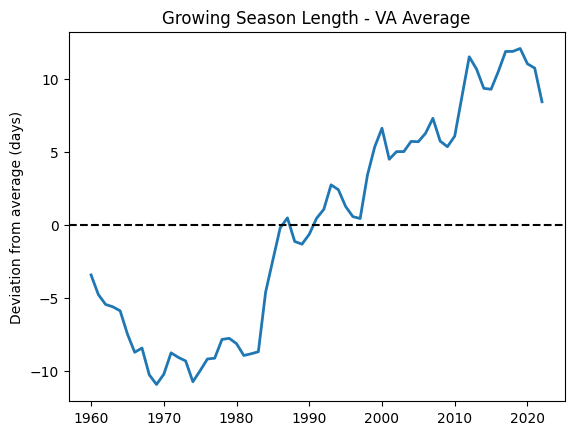

In [10]:
# Plot rolling averages of growing season length deviations from mean
# ie. "frost free period / duration "
# smoother time series 

rollavg_growing_season = va_growing_seasons.duration_days.rolling(rolling_annual_window).mean().dropna()

fig, ax = plt.subplots()
ax.plot(
    rollavg_growing_season.index, 
    rollavg_growing_season.mean(axis=1) - rollavg_growing_season.mean(axis=0).mean(), 
    linewidth=2,
)


ax.axhline(0, color='k', linestyle='--')
ax.set_ylabel("Deviation from average (days)")
ax.set_title("Growing Season Length - VA Average")
plt.show()

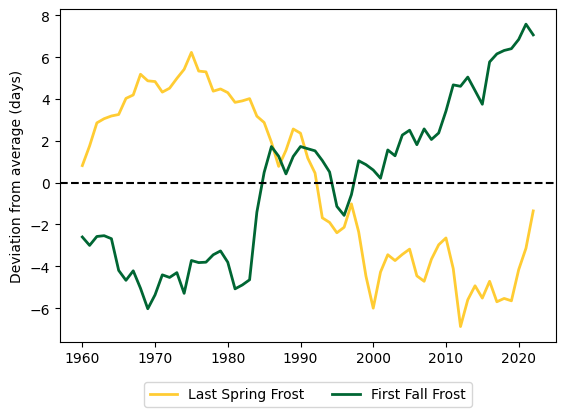

In [11]:
# Plot rolling averages of frost date daviations from mean together
rollavg_season_start = va_growing_seasons.season_start_doy.rolling(rolling_annual_window).mean().dropna()
rollavg_season_end = va_growing_seasons.season_end_doy.rolling(rolling_annual_window).mean().dropna()

fig, ax = plt.subplots()
ax.plot(
    rollavg_season_start.index, 
    rollavg_season_start.mean(axis=1) - rollavg_season_start.mean(axis=0).mean(), 
    color='#FFCC33', label="Last Spring Frost", linewidth=2,
)
ax.plot(
    rollavg_season_end.index, 
    rollavg_season_end.mean(axis=1) - rollavg_season_end.mean(axis=0).mean(), 
    color='#006633',
    label="First Fall Frost", linewidth=2,
)


ax.axhline(0, color='k', linestyle='--')
ax.set_ylabel("Deviation from average (days)")

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.show()